## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [9]:
import numpy as np
import cv2
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

with open('calibrate.p', 'rb') as f:
    calibrate = pickle.load(f)

mtx = calibrate['mtx']
dist = calibrate['dist']

## And so on and so forth...

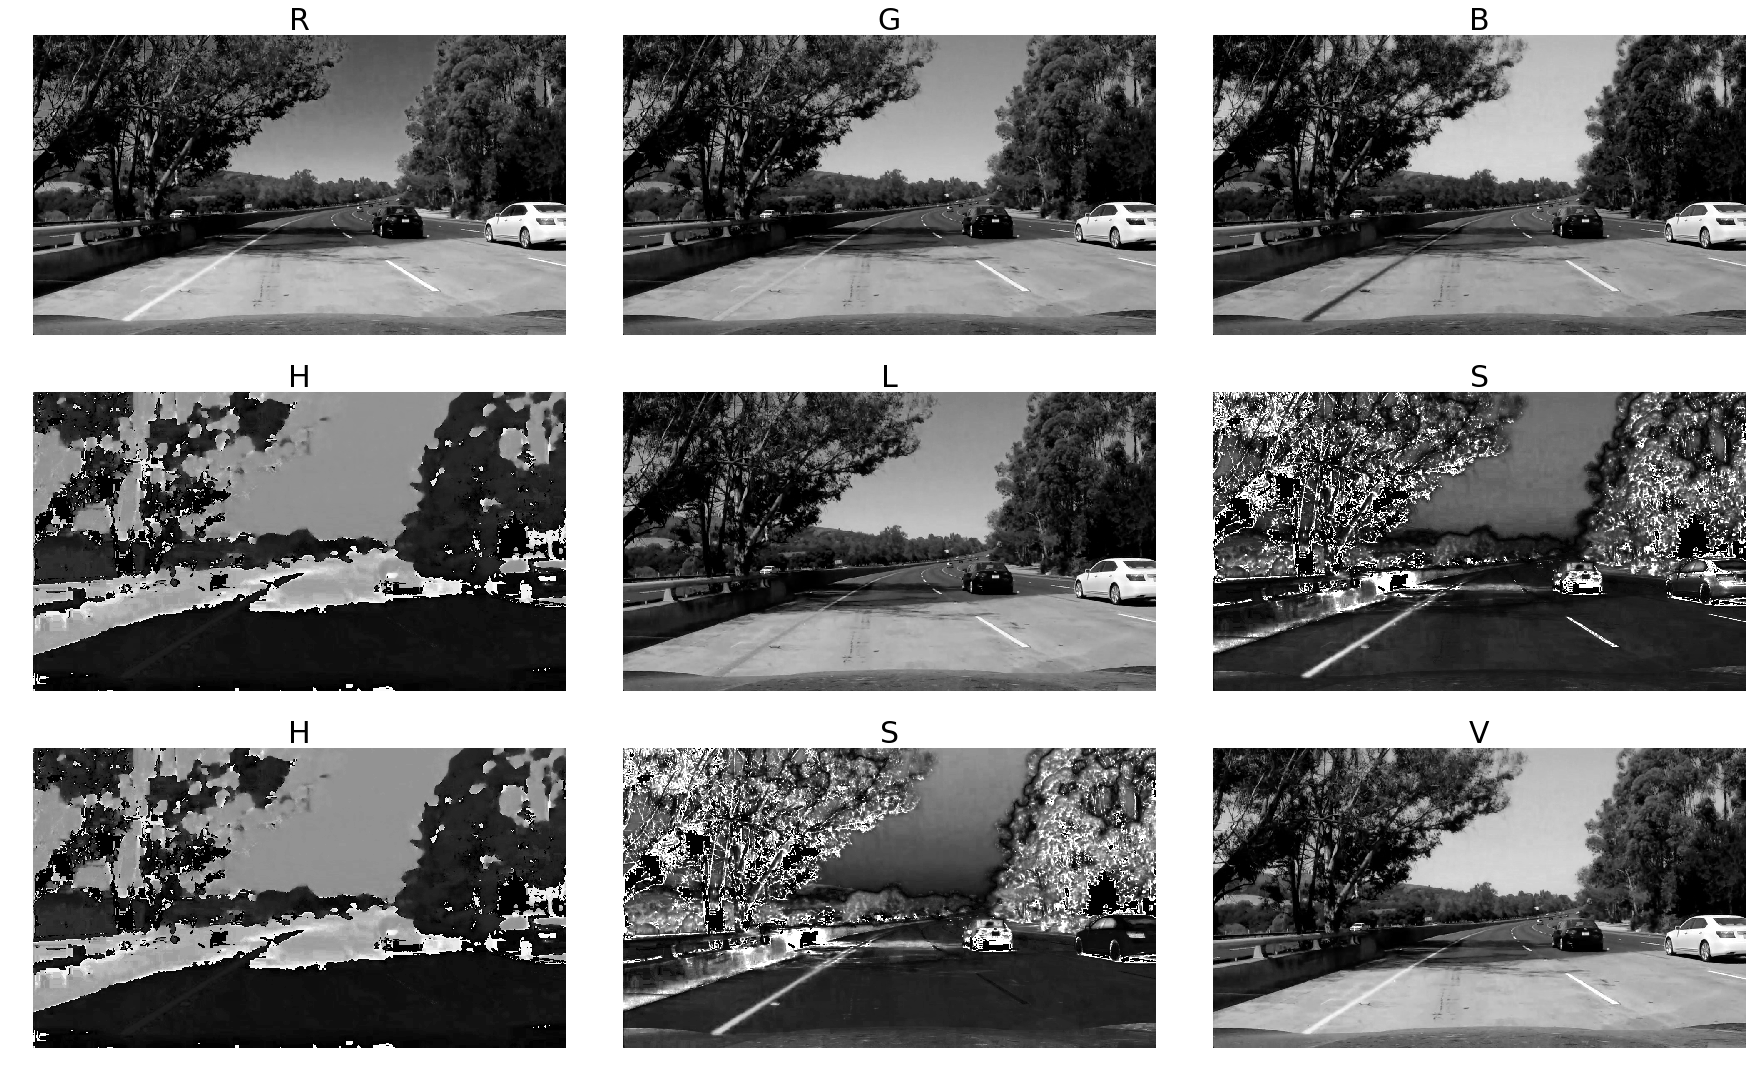

In [10]:
def imread(fname):
    return cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)

def convert_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def convert_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def gaussian_blur(img, kernel=(3,3), debug=False):
    return cv2.GaussianBlur(img, kernel, 0)

img = imread('./test_images/test5.jpg')
fig, axs = plt.subplots(3, 3, figsize=(25, 15))
fig.subplots_adjust(hspace=.2, wspace=.001)
axs = axs.ravel()

labels = ['R', 'G', 'B', 'H', 'L', 'S', 'H', 'S', 'V']
channels = cv2.split(img)
channels.extend(cv2.split(convert_hls(img)))
channels.extend(cv2.split(convert_hsv(img)))

for i in range(len(labels)):
    axs[i].imshow(channels[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(labels[i], size=30)
    
plt.tight_layout()
plt.savefig('example_images/color_space.png')

In [56]:
from threshold import SobelThreshold
from threshold import ColorThreshold
sobel_threshold = SobelThreshold(thresh=(30,100))
color_threshold = ColorThreshold()

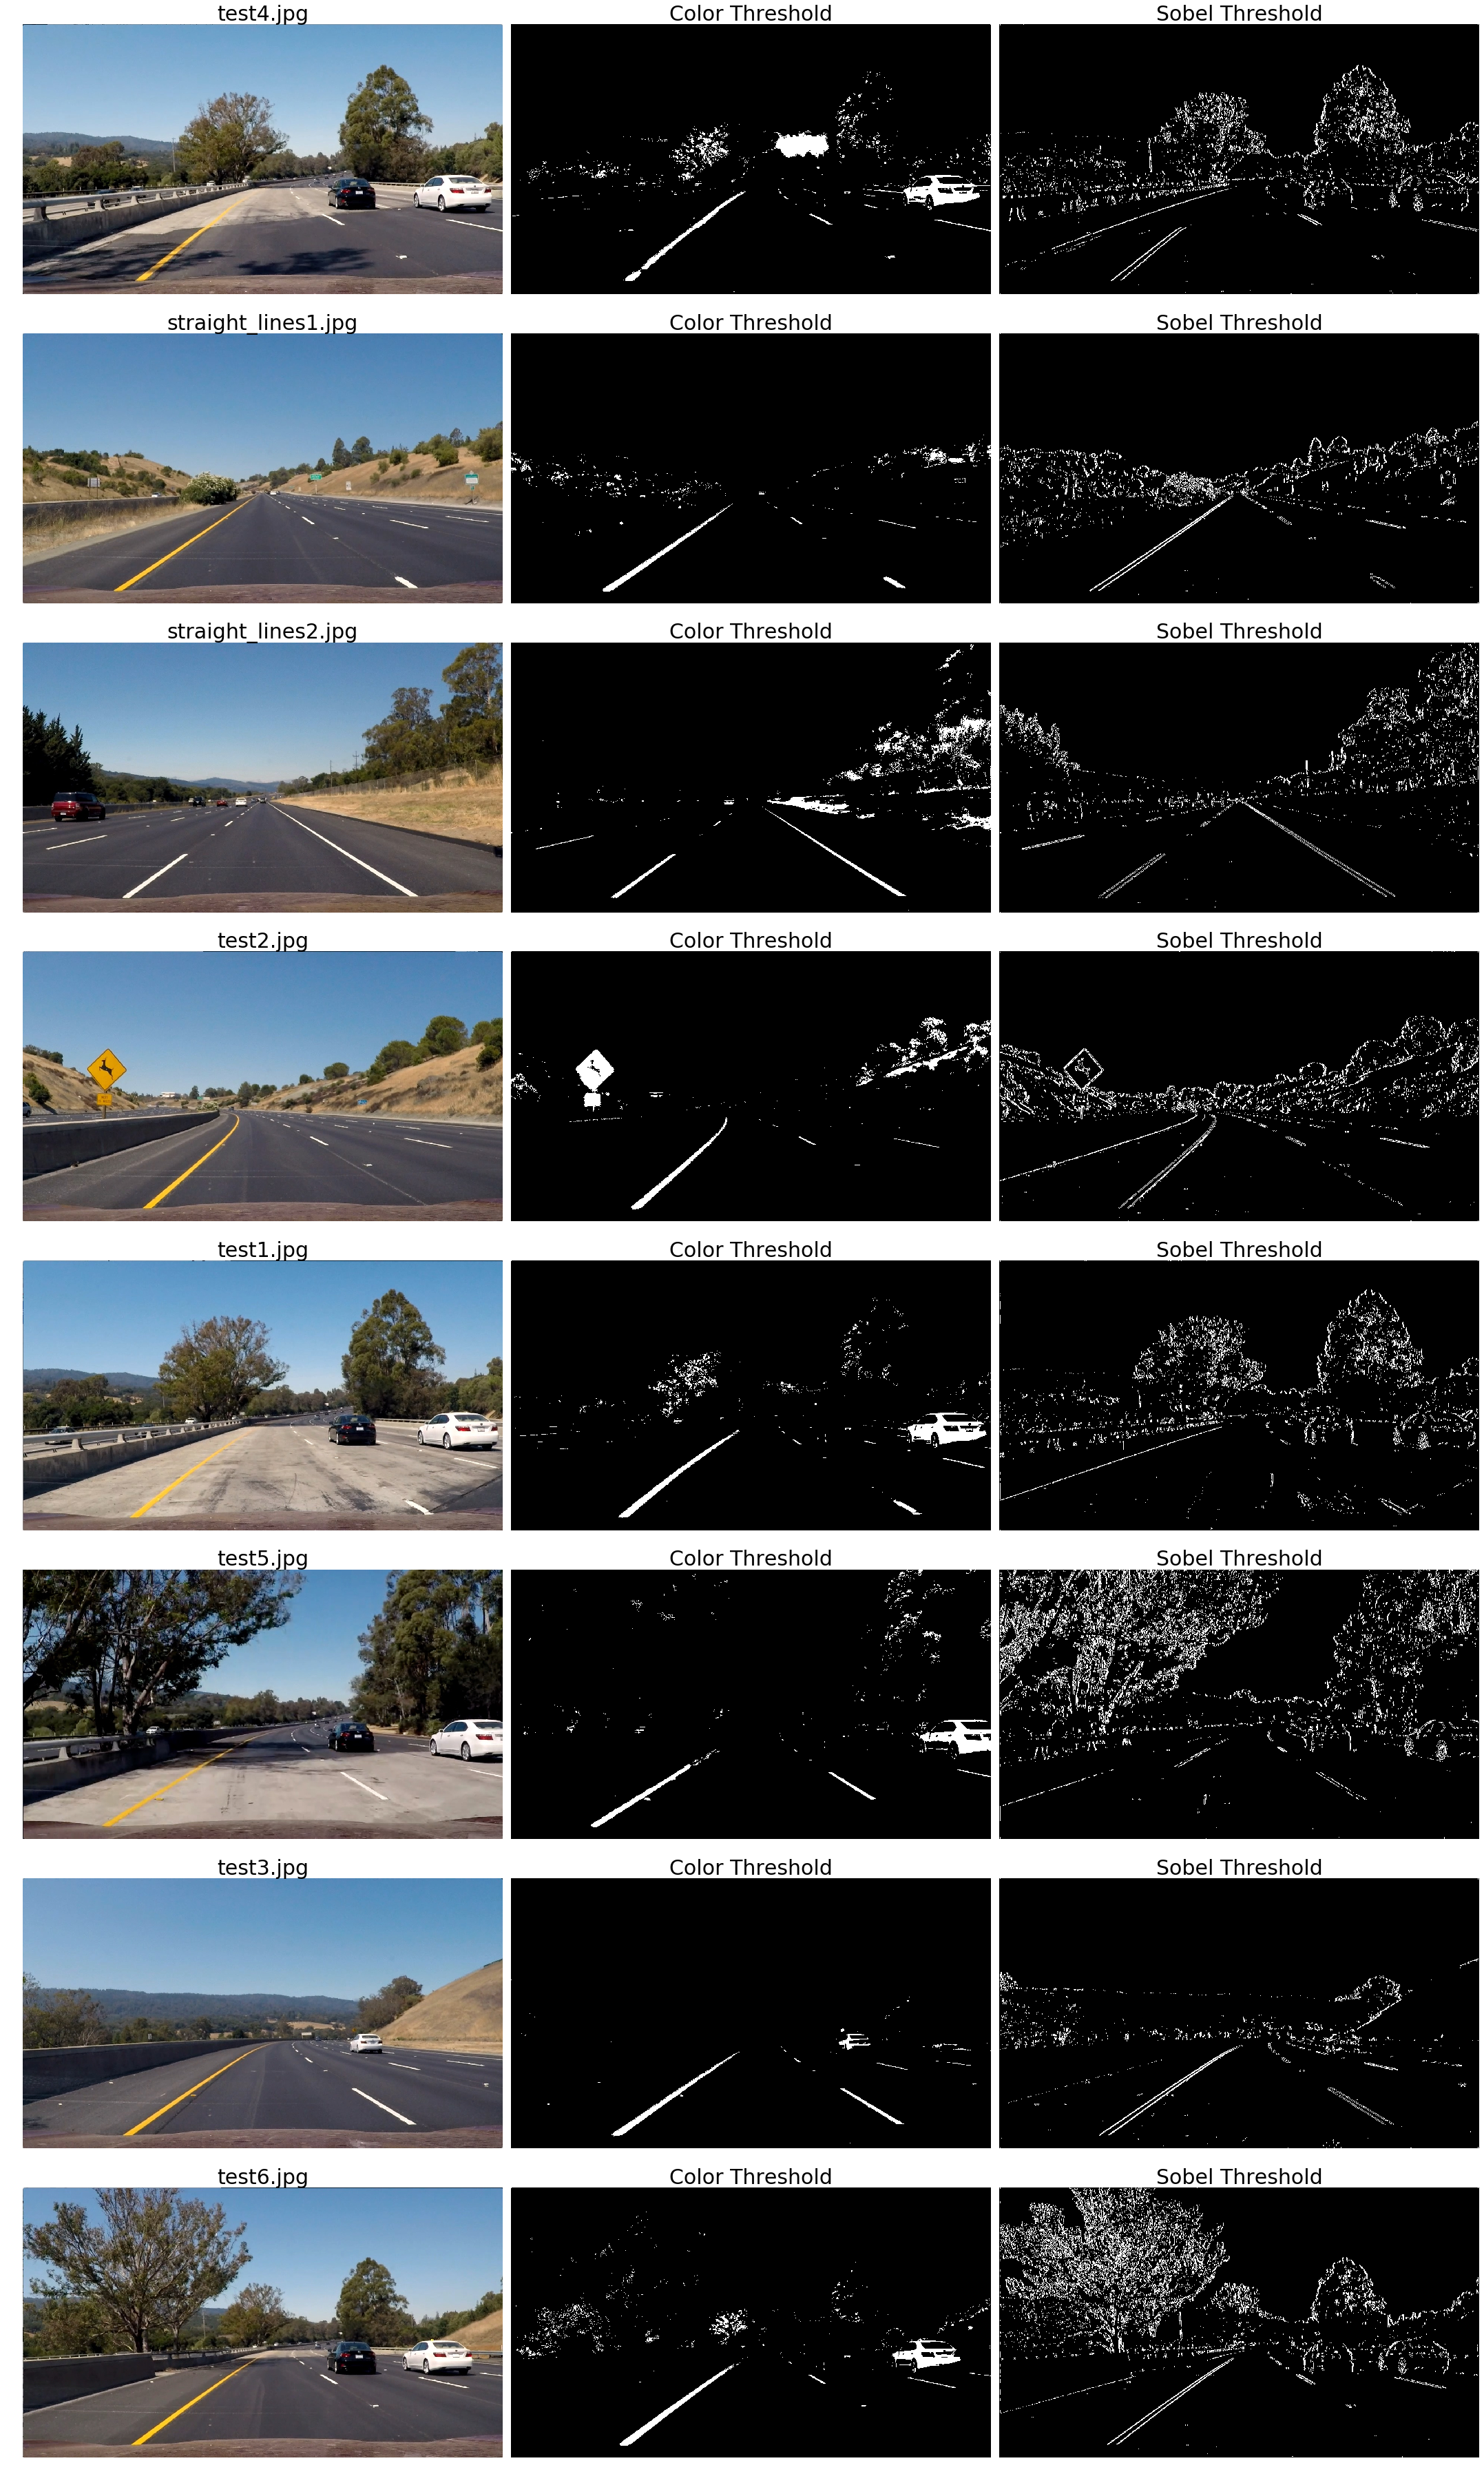

In [57]:
paths = list(Path('./test_images').glob('*.jpg'))
fig, axs = plt.subplots(len(paths), 3, figsize=(30, 50))
fig.subplots_adjust(hspace=.2, wspace=.001)
axs = axs.ravel()

for i, path in enumerate(paths):
    img = imread(path.as_posix())
    idx = 3*i
    axs[idx].imshow(img)
    axs[idx].axis('off')
    axs[idx].set_title(path.name, size=30)
    
    idx += 1
    color_filtered = color_threshold.threshold(img)
    axs[idx].imshow(color_filtered, cmap='gray')
    axs[idx].axis('off')
    axs[idx].set_title('Color Threshold', size=30)
    
    idx += 1
    sobel_filtered = sobel_threshold.threshold(img)
    axs[idx].imshow(sobel_filtered, cmap='gray')
    axs[idx].axis('off')
    axs[idx].set_title('Sobel Threshold', size=30)    

plt.tight_layout()
plt.savefig('example_images/thresold.png')

In [58]:
from lane_detector import LaneDetector

detector = LaneDetector(margin=150)

def warp(img, mtx, dist, debug=False):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    w = undistorted.shape[1]
    h = undistorted.shape[0]
    src = np.float32([[603, 450],[w-603, 450], [w-280, h], [280, h]])
    dst = np.float32([[300, 0], [w-300, 0], 
                      [w-300, h],[300, h]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistorted, M, (w, h), flags=cv2.INTER_LINEAR)
    
    if debug:
        plt.imshow(warped, cmap='gray')
        plt.show()
        
    return warped

def process(img, debug=False):
    color_filtered = color_threshold.threshold(img)
    sobel_filtered = sobel_threshold.threshold(img)
    filter_ = np.zeros_like(color_filtered)
    filter_[(color_filtered > 0) | (sobel_filtered > 0)] = 1
    
    warped = warp(filter_, mtx, dist, debug=debug)

    out = detector.fit_polynomial(warped)
    if debug:
        detector.reset()
        plt.imshow(out, cmap='gray')
        plt.show()
    return out

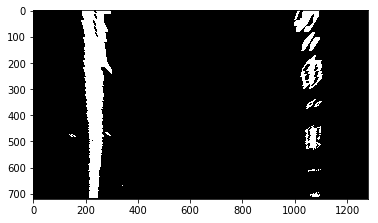

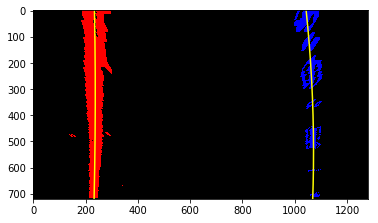

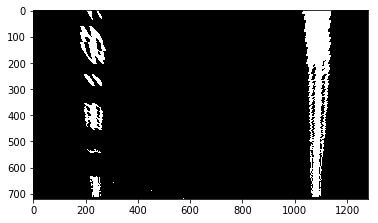

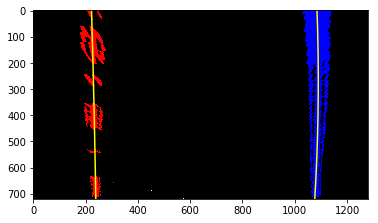

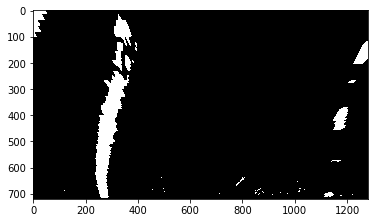

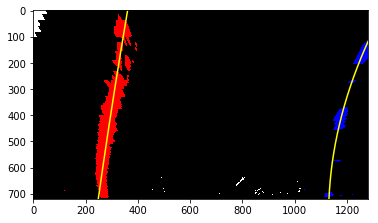

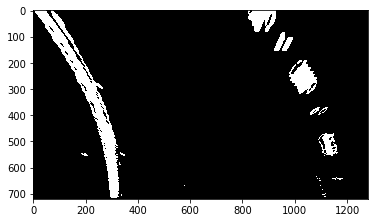

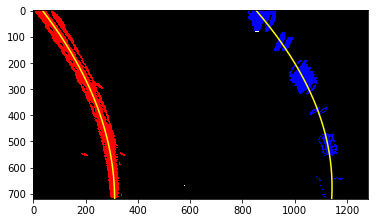

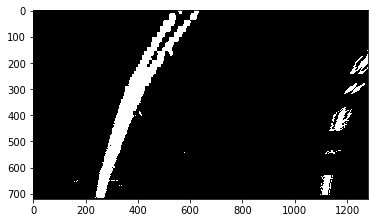

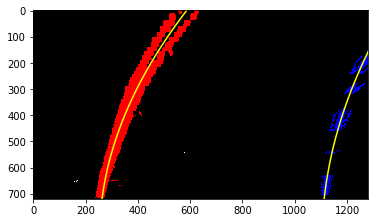

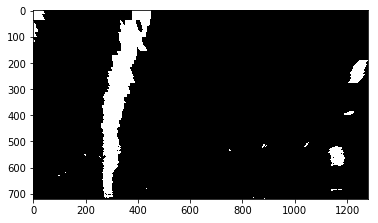

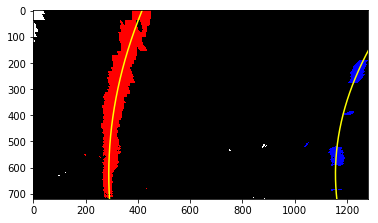

In [59]:
process(imread('./test_images/straight_lines1.jpg'), debug=True)
process(imread('./test_images/straight_lines2.jpg'), debug=True)
process(imread('./test_images/test1.jpg'), debug=True)
process(imread('./test_images/test2.jpg'), debug=True)
process(imread('./test_images/test3.jpg'), debug=True)
_ = process(imread('./test_images/test4.jpg'), debug=True)

In [60]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [61]:
def process_image(image):
    return process(image)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [04:14<00:00,  4.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 1min 40s, sys: 1.24 s, total: 1min 42s
Wall time: 4min 15s


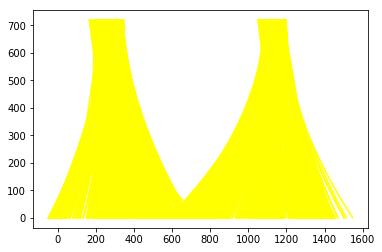

In [62]:
project_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image)
%time project_clip.write_videofile(project_output, audio=False)